# Unsupervised Learning Hands On

## 1. Download data of today's example (preprocessed Table):

**Gene expression data for cancer samples from the TCGA database**: 

In [3]:
import numpy as np
import pandas as pd

#read precalculated csv table "TCGA-cancer-DF.zip
df_noNA=pd.read_csv("https://cloud.inf.ethz.ch/s/c64nqrB4SJkaHDF/download", index_col=0,compression="zip")  
df_noNA.head()

,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZYG11B,ZYX,ZZEF1,ZZZ3,stage,age,gender,status,time,type
TCGA-61-1910-01,-0.04126,4.7860,5.040,-6.683,-0.5449,-0.000557,3.3340,2.58300,-0.0893,-0.001292,...,-0.1832,1.6160,0.4057,0.58240,Stage IIC,-20779,FEMALE,LIVING,1127,OV
TCGA-61-1728-01,-0.04126,2.0640,2.149,-2.271,-0.6134,-0.000557,0.3176,-0.54440,-0.0893,-0.001292,...,-0.3968,1.3070,-1.4040,0.28320,Stage IV,-21582,FEMALE,LIVING,848,OV
TCGA-09-1666-01,-0.04126,1.7720,2.805,-2.959,0.4053,-0.000557,0.5211,1.16200,-0.0893,-0.001292,...,0.6730,1.3920,-0.9993,0.67380,Stage IIIC,-21066,FEMALE,LIVING,1752,OV
TCGA-24-1469-01,-0.04126,2.1020,2.402,-1.069,0.4796,-0.000557,0.1432,-0.08483,0.7185,-0.001292,...,-0.5974,0.7653,-0.4181,-0.07337,Stage IIIC,-25937,FEMALE,LIVING,277,OV
TCGA-61-1917-01,-0.04126,0.5883,2.380,-1.513,0.3045,-0.000557,-0.6307,-0.54440,-0.0893,-0.001292,...,-0.4541,1.2990,-1.1600,0.03223,Stage IIIB,-21972,FEMALE,DECEASED,1321,OV


## 2. Create matrix X with independent variable and a dataframe with survival information


In [184]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

#keep only breast cancer:
df_noNA_reduced=df_noNA.loc[df_noNA['type']=="BRCA"]

#keep only clinical information and some important genes https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0241924#:~:text=We%20found%20that%20the%206,prognosis%20of%20breast%20cancer%20patients :
df_noNA_reduced=df_noNA_reduced[['CD24', 'PRRG1', 'IQSEC3', 'RCC2', 'CASP8','ERBB2','stage', 'age', 'status', 'time']]

#replace Gender by 0 and 1
dictionary = {'LIVING': 0, 'DECEASED': 1}
df_noNA_reduced=df_noNA_reduced.replace({'status': dictionary})

#replace Stage with floats
dictionary = {'LIVING': 0, 'DECEASED': 1}
df_noNA_reduced=df_noNA_reduced.replace({'status': dictionary})

dictionary = {'Stage I': 1.5, 'Stage IA': 1.4, 'Stage IB': 1.6, 'Stage II': 2.5, 'Stage IIA': 2.4, 'Stage IIB': 2.6,
    'Stage III': 3.5, 'Stage IIIA': 3.4, 'Stage IIIB': 3.6, 'Stage IIIC': 3.8, 'Stage IV': 4.5}
df_noNA_reduced=df_noNA_reduced.replace({'stage': dictionary})
    
#remove entries with 0 time after the last follow-up: 
df_noNA_reduced=df_noNA_reduced.loc[df_noNA_reduced['time']>0]


X = df_noNA_reduced.drop(columns=['status', 'time'])
y = df_noNA_reduced[['status', 'time']]

print("Total number of samples: %d " %X.shape[0])

X.head()

Total number of samples: 1029 


,CD24,PRRG1,IQSEC3,RCC2,CASP8,ERBB2,stage,age
TCGA-BH-A0BQ-01,0.6038,-0.3081,-0.4818,0.411800,0.530000,1.9190,1.5,-14494
TCGA-BH-A0BT-01,1.4430,-2.0550,-2.1110,0.639100,0.834700,2.3710,2.4,-20625
TCGA-BH-A0C7-01,2.2340,-0.7025,-2.0890,0.278200,0.009503,1.8370,2.6,-17871
TCGA-AC-A5XU-01,2.9040,-1.7450,-0.1900,0.004756,0.379700,0.8005,2.6,-27191
TCGA-PE-A5DE-01,-0.8199,-1.6940,-0.6700,0.555700,0.658800,0.3966,2.4,-15216


## 3. Visualize the data:

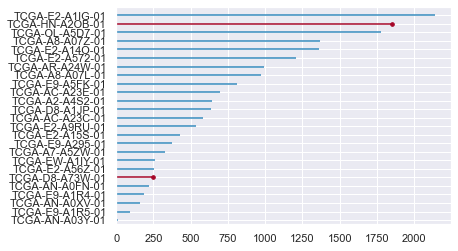

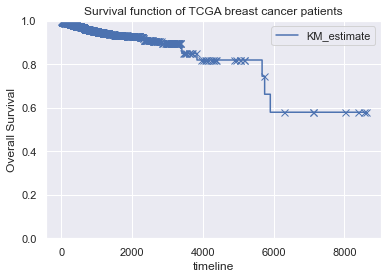

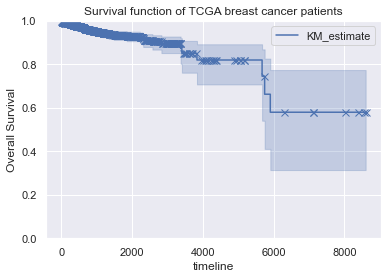

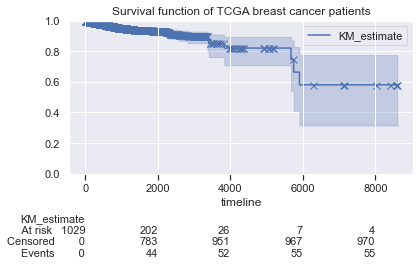

Median survival time (estimate): inf 
Median survival time (estimate) confidence interval: 5749.000000-inf 


In [170]:
from lifelines.plotting import plot_lifetimes # conda install -c conda-forge lifelines
from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt
from lifelines.utils import median_survival_times


#Visualize survival data for random 25 individuals from our dataset
y_25=y.sample(n=25, random_state=14)
plot_lifetimes(y_25['time'],  event_observed=y_25['status'])
plt.show()


#Visualize survival data for random all individuals using the Kaplan-Meier curve
kmf = KaplanMeierFitter()
kmf.fit(y['time'], event_observed=y['status'])

kmf.plot_survival_function(show_censors=True, censor_styles={'ms': 7, 'marker': 'x'}, ci_show=False)
plt.title('Survival function of TCGA breast cancer patients');
plt.ylim(0, 1)
plt.ylabel("Overall Survival")
plt.show()

#Visualize survival data for random all individuals using the Kaplan-Meier curve - add confidence intervals 
kmf.plot_survival_function(show_censors=True, censor_styles={'ms': 7, 'marker': 'x'}, ci_show=True)
plt.title('Survival function of TCGA breast cancer patients');
plt.ylim(0, 1)
plt.ylabel("Overall Survival")
plt.show()

#Visualize survival data for random all individuals using the Kaplan-Meier curve - add counts of patients at risk
kmf.plot_survival_function(show_censors=True, censor_styles={'ms': 7, 'marker': 'x'}, ci_show=True, at_risk_counts=True)
plt.title('Survival function of TCGA breast cancer patients');
plt.ylim(0, 1)
plt.ylabel("Overall Survival")
plt.show()


#Print median survival time, and its 95% confidence interval :
print("Median survival time (estimate): %f " %kmf.median_survival_time_)

median_ci = median_survival_times(kmf.confidence_interval_)
print("Median survival time (estimate) confidence interval: %f-%f " %(median_ci['KM_estimate_lower_0.95'],median_ci['KM_estimate_upper_0.95']))


## 4. Plot KM curves for patients overexpressing HER2 (official gene name ERBB2)

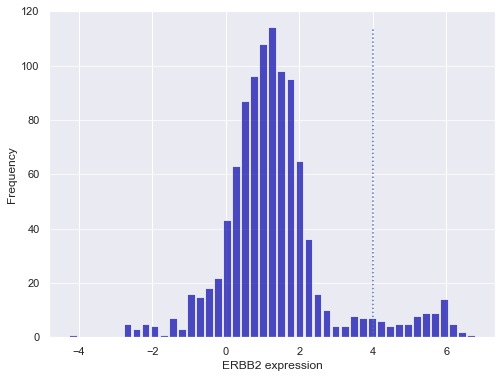

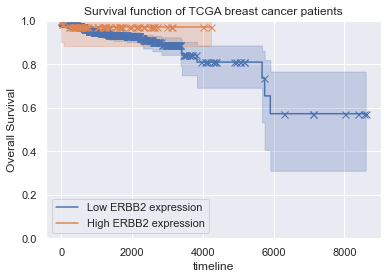

In [172]:
# Plot histogram for the ERBB2 expression:
fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(8, 6)
n, bins, patches = ax1.hist(x=X['ERBB2'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
ax1.grid(axis='y', alpha=0.75)
ax1.set_xlabel('ERBB2 expression')
ax1.set_ylabel('Frequency')
maxfreq = n.max()
# Set a clean upper y-axis limit.
ax1.set_ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)


#Let's use threshold of 4 to get patients with overexpressed ERBB2:
exp_threshold=4
plt.vlines(x=exp_threshold, ymin=0, ymax=maxfreq ,colors=None, linestyles='dotted')

plt.show()

i1=(X['ERBB2'] <= exp_threshold)
i2=(X['ERBB2'] > exp_threshold)

#Plot KM curves for the two groups of patients:

kmf = KaplanMeierFitter()
kmf.fit(y['time'][i1], event_observed=y['status'][i1])
kmf.plot_survival_function(show_censors=True, censor_styles={'ms': 7, 'marker': 'x'}, ci_show=True, label="Low ERBB2 expression")

kmf.fit(y['time'][i2], event_observed=y['status'][i2])
kmf.plot_survival_function(show_censors=True, censor_styles={'ms': 7, 'marker': 'x'}, ci_show=True, label="High ERBB2 expression")
plt.legend(loc="lower left", shadow=False, scatterpoints=1)

plt.title('Survival function of TCGA breast cancer patients');
plt.ylim(0, 1)
plt.ylabel("Overall Survival")
plt.show()



## 5. Calculate log-rank test for these two groups

In [142]:
from lifelines.statistics import logrank_test

results = logrank_test(y['time'][i1], y['time'][i2], event_observed_A=y['status'][i1], event_observed_B=y['status'][i2])
results.print_summary()

print(results.p_value)        # 0.4047795

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.69 0.40      1.30

0.40477950076952696


## 6. Try different splits for log-rank test

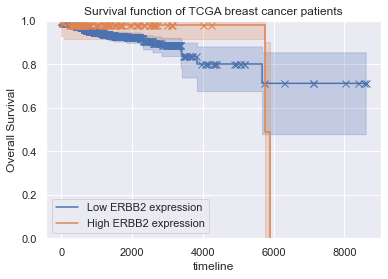

p-value for threshold = 3.000000 : 0.451950


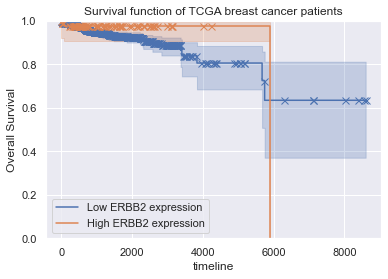

p-value for threshold = 3.500000 : 0.400256


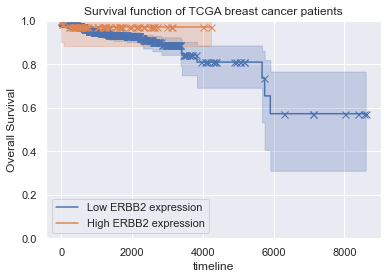

p-value for threshold = 4.000000 : 0.404780


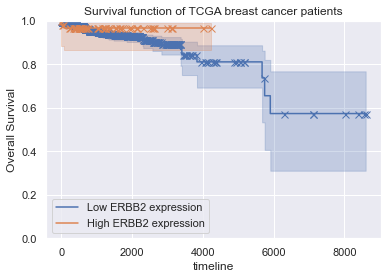

p-value for threshold = 4.500000 : 0.549602


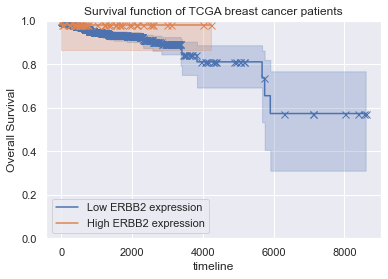

p-value for threshold = 5.000000 : 0.323724

Initial p-values:
[0.45195032 0.40025612 0.4047795  0.54960152 0.32372361]

Adjusted p-values:
[0.54960152 0.54960152 0.54960152 0.54960152 0.54960152]


In [162]:
import statsmodels.stats.multitest as multi

thresholds = (3,3.5,4,4.5,5)

pvalues=np.ones(len(thresholds))

for ind, threshold_value in enumerate(thresholds):    
    i1=(X['ERBB2'] <= threshold_value)
    i2=(X['ERBB2'] > threshold_value)

    #Plot KM curves for the two groups of patients:
    kmf = KaplanMeierFitter()
    kmf.fit(y['time'][i1], event_observed=y['status'][i1])
    kmf.plot_survival_function(show_censors=True, censor_styles={'ms': 7, 'marker': 'x'}, ci_show=True, label="Low ERBB2 expression")
    kmf.fit(y['time'][i2], event_observed=y['status'][i2])
    kmf.plot_survival_function(show_censors=True, censor_styles={'ms': 7, 'marker': 'x'}, ci_show=True, label="High ERBB2 expression")
    plt.legend(loc="lower left", shadow=False, scatterpoints=1)
    plt.title('Survival function of TCGA breast cancer patients');
    plt.ylim(0, 1)
    plt.ylabel("Overall Survival")
    plt.show()
    results = logrank_test(y['time'][i1], y['time'][i2], event_observed_A=y['status'][i1], event_observed_B=y['status'][i2])
    print("p-value for threshold = %f : %f" % (threshold_value,results.p_value))
    pvalues[ind]=results.p_value

print("\nInitial p-values:")
print(pvalues)
print("\nAdjusted p-values:")
_, pvals_adj, _, _ = multi.multipletests(pvalues, alpha=0.05, method='fdr_bh')
print(pvals_adj)



## 7. Plot smoothed hasard function

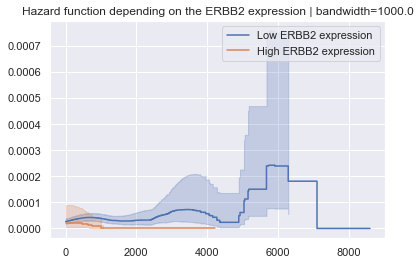

In [180]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()

bandwidth = 1000

exp_threshold=4
i1=(X['ERBB2'] <= exp_threshold)
i2=(X['ERBB2'] > exp_threshold)


naf.fit(y['time'][i1], event_observed=y['status'][i1], label="Low ERBB2 expression")
ax = naf.plot_hazard(bandwidth=bandwidth)

naf.fit(y['time'][i2], event_observed=y['status'][i2], label="High ERBB2 expression")
naf.plot_hazard(ax=ax, bandwidth=bandwidth)

plt.title("Hazard function depending on the ERBB2 expression | bandwidth=%.1f" % bandwidth);


## 8. Run Cox proportional hazard model

In [194]:
from lifelines import CoxPHFitter
from sklearn.preprocessing import StandardScaler

#stardartize the data (so that coefficients make more sense):
scaled_X = X.copy()
col_names = X.columns
features = scaled_X[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_X[col_names] = features

scaled_data=pd.concat([scaled_X, y], axis=1)

cph=CoxPHFitter()
cph.fit(scaled_data, "time", event_col="status")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1029 total observations, 974 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 1029
number of events observed = 55
   partial log-likelihood = -303.53
         time fit was run = 2021-04-14 15:05:07 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
CD24        0.29       1.34       0.16            -0.03             0.61                 0.97                 1.83
PRRG1       0.06       1.06       0.15            -0.24             0.36                 0.79                 1.43
IQSEC3      0.24       1.27       0.15            -0.05             0.53                 0.95                 1.69
RCC2       -0.24       0.79       0.16            -0.56             0.08                 0.57                 1.08
CASP8      -0.16       0.85       0.15            -0.45             0.13                 0.64                 1.14
ERBB2      -0.13       0.88       0.17            -0.46             0.20                 0.63                 1.22
stage       0.67       1.96       0.13             0.41             0.93                 1.51                 2.55
age        -0.53       0.59       0.15            -0.82            -0.24                 0.44                 0.79

              z      p   -log2(p)
covariate                        
CD24       1.80   0.07       3.78
PRRG1      0.39   0.70       0.52
IQSEC3     1.64   0.10       3.32
RCC2      -1.46   0.14       2.81
CASP8     -1.10   0.27       1.88
ERBB2     -0.80   0.43       1.23
stage      5.08 <0.005      21.30
age       -3.58 <0.005      11.49
---
Concordance = 0.76
Partial AIC = 623.05
log-likelihood ratio test = 50.08 on 8 df
-log2(p) of ll-ratio test = 24.60

## 9. Plot log(hasard ratio)

<AxesSubplot:xlabel='log(HR) (95% CI)'>

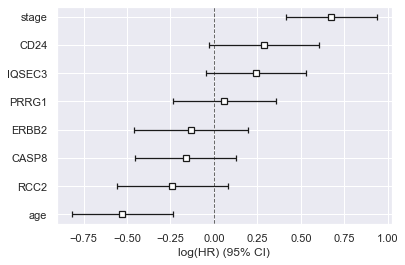

In [196]:
cph.plot()

## 10. Build Cox regression on train and validate on test

In [221]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_data.drop(columns=['time','status']), scaled_data[['time','status']], test_size=0.3, shuffle=True, random_state=42) 

#Train CoxPH model on the 70% of the data
print("Training CoxPH model on the train set (70% of data)")
cph=CoxPHFitter()
cph.fit(pd.concat([X_train, y_train], axis=1), "time", event_col="status")
cph.print_summary()

#Validate on the test set (30% of the data)
expectedEventTime=cph.predict_expectation(pd.concat([X_test, y_test], axis=1))


# Print the c-index for the test set:
print('\nConcordance index on the test set (30%% of the data): %.2f' % cph.score(pd.concat([X_test, y_test], axis=1), scoring_method ='concordance_index'))

Training CoxPH model on the train set (70% of data)


<lifelines.CoxPHFitter: fitted with 720 total observations, 675 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 720
number of events observed = 45
   partial log-likelihood = -226.97
         time fit was run = 2021-04-15 13:29:26 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
CD24        0.29       1.34       0.20            -0.09             0.67                 0.91                 1.96
PRRG1       0.02       1.02       0.17            -0.32             0.36                 0.72                 1.43
IQSEC3      0.30       1.35       0.18            -0.06             0.65                 0.95                 1.92
RCC2       -0.30       0.74       0.19            -0.66             0.07                 0.51                 1.07
CASP8      -0.15       0.86       0.17            -0.47             0.18                 0.62                 1.20
ERBB2      -0.17       0.85       0.19            -0.54             0.20                 0.59                 1.22
stage       0.75       2.11       0.15             0.46             1.04                 1.58                 2.82
age        -0.39       0.67       0.17            -0.73            -0.06                 0.48                 0.94

              z      p   -log2(p)
covariate                        
CD24       1.49   0.14       2.89
PRRG1      0.09   0.93       0.11
IQSEC3     1.65   0.10       3.33
RCC2      -1.58   0.11       3.14
CASP8     -0.87   0.38       1.39
ERBB2     -0.88   0.38       1.41
stage      5.09 <0.005      21.42
age       -2.32   0.02       5.62
---
Concordance = 0.79
Partial AIC = 469.95
log-likelihood ratio test = 43.95 on 8 df
-log2(p) of ll-ratio test = 20.71


Concordance index on the test set (30% of the data): 0.64


## 11. Build Cox regression with clinical data only on train and validate on test

In [222]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_data[['stage', 'age']], scaled_data[['time','status']], test_size=0.3, shuffle=True, random_state=42) 

#Train CoxPH model on the 70% of the data
print("Training CoxPH model on the train set (70% of data)")
cph=CoxPHFitter()
cph.fit(pd.concat([X_train, y_train], axis=1), "time", event_col="status")
cph.print_summary()

#Validate on the test set (30% of the data)
expectedEventTime=cph.predict_expectation(pd.concat([X_test, y_test], axis=1))


# Print the c-index for the test set:
print('\nConcordance index on the test set (30%% of the data): %.2f' % cph.score(pd.concat([X_test, y_test], axis=1), scoring_method ='concordance_index'))

Training CoxPH model on the train set (70% of data)


<lifelines.CoxPHFitter: fitted with 720 total observations, 675 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 720
number of events observed = 45
   partial log-likelihood = -232.74
         time fit was run = 2021-04-15 13:29:31 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
stage       0.73       2.07       0.14             0.45             1.00                 1.57                 2.71
age        -0.40       0.67       0.15            -0.70            -0.10                 0.49                 0.91

              z      p   -log2(p)
covariate                        
stage      5.23 <0.005      22.48
age       -2.59   0.01       6.71
---
Concordance = 0.73
Partial AIC = 469.48
log-likelihood ratio test = 32.42 on 2 df
-log2(p) of ll-ratio test = 23.39


Concordance index on the test set (30% of the data): 0.70


## 12. Build Cox regression excluding clinical data on train and validate on test

In [223]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_data.drop(columns=['time','status','stage', 'age']), scaled_data[['time','status']], test_size=0.3, shuffle=True, random_state=42) 

#Train CoxPH model on the 70% of the data
print("Training CoxPH model on the train set (70% of data)")
cph=CoxPHFitter()
cph.fit(pd.concat([X_train, y_train], axis=1), "time", event_col="status")
cph.print_summary()

#Validate on the test set (30% of the data)
expectedEventTime=cph.predict_expectation(pd.concat([X_test, y_test], axis=1))


# Print the c-index for the test set:
print('\nConcordance index on the test set (30%% of the data): %.2f' % cph.score(pd.concat([X_test, y_test], axis=1), scoring_method ='concordance_index'))

Training CoxPH model on the train set (70% of data)


<lifelines.CoxPHFitter: fitted with 720 total observations, 675 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 720
number of events observed = 45
   partial log-likelihood = -241.74
         time fit was run = 2021-04-15 13:29:41 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
CD24        0.36       1.43       0.20            -0.03             0.75                 0.97                 2.12
PRRG1      -0.10       0.90       0.16            -0.41             0.21                 0.66                 1.23
IQSEC3      0.20       1.22       0.17            -0.14             0.54                 0.87                 1.71
RCC2       -0.49       0.61       0.18            -0.84            -0.14                 0.43                 0.87
CASP8      -0.15       0.86       0.16            -0.47             0.16                 0.63                 1.18
ERBB2      -0.10       0.90       0.18            -0.45             0.25                 0.64                 1.29

              z    p   -log2(p)
covariate                      
CD24       1.80 0.07       3.79
PRRG1     -0.64 0.52       0.94
IQSEC3     1.15 0.25       2.00
RCC2      -2.77 0.01       7.47
CASP8     -0.95 0.34       1.56
ERBB2     -0.56 0.58       0.80
---
Concordance = 0.69
Partial AIC = 495.47
log-likelihood ratio test = 14.43 on 6 df
-log2(p) of ll-ratio test = 5.31


Concordance index on the test set (30% of the data): 0.57


## 13. Build LASSO Cox regression on train and validate on test

In [237]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data.drop(columns=['time','status']), scaled_data[['time','status']], test_size=0.3, shuffle=True, random_state=42) 

#Train LASSO CoxPH model on the 70% of the data
print("Training CoxPH model on the train set (70% of data)")

myLambda=0.04 #in theory, you can find the best values of Lambda using Cross-Validation (check the lecture and Jupiter NB on Regression)

print('Will use Lambda = %.2f' % myLambda)

cph=CoxPHFitter(penalizer=myLambda, l1_ratio = 1) # set l1_ratio = 0 to do Ridge regression, or a value between 0 and 1 for the Elastic Net
cph.fit(pd.concat([X_train, y_train], axis=1), "time", event_col="status")
cph.print_summary()

#Validate on the test set (30% of the data)
expectedEventTime=cph.predict_expectation(pd.concat([X_test, y_test], axis=1))


# Print the c-index for the test set:
print('\nConcordance index on the test set (30%% of the data): %.2f' % cph.score(pd.concat([X_test, y_test], axis=1), scoring_method ='concordance_index'))

Training CoxPH model on the train set (70% of data)
Will use Lambda = 0.04


<lifelines.CoxPHFitter: fitted with 720 total observations, 675 right-censored observations>
             duration col = 'time'
                event col = 'status'
                penalizer = 0.04
                 l1 ratio = 1
      baseline estimation = breslow
   number of observations = 720
number of events observed = 45
   partial log-likelihood = -244.50
         time fit was run = 2021-04-15 14:01:14 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
CD24        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
PRRG1       0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
IQSEC3      0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
RCC2       -0.05       0.96       0.16            -0.37             0.28                 0.69                 1.32
CASP8      -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ERBB2      -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
stage       0.43       1.53       0.15             0.14             0.71                 1.15                 2.04
age        -0.04       0.96       0.16            -0.36             0.27                 0.70                 1.31

              z      p   -log2(p)
covariate                        
CD24       0.00   1.00       0.00
PRRG1      0.00   1.00       0.00
IQSEC3     0.00   1.00       0.00
RCC2      -0.27   0.78       0.35
CASP8     -0.00   1.00       0.00
ERBB2     -0.00   1.00       0.00
stage      2.94 <0.005       8.23
age       -0.27   0.79       0.34
---
Concordance = 0.75
Partial AIC = 504.99
log-likelihood ratio test = 8.91 on 8 df
-log2(p) of ll-ratio test = 1.51


Concordance index on the test set (30% of the data): 0.61


## 14. Run Random Survival Forest on our data

In [285]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2 #conda install -c sebp scikit-survival
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

y=scaled_data[['status','time']]
y["status"] = y["status"].astype(bool)
y=y.to_records(index=False)

X_train, X_test, y_train, y_test = train_test_split(scaled_data.drop(columns=['status','time']), y, test_size=0.3, shuffle=True, random_state=42) 

#Train Random Forest model on the 70% of the data
print("Training Random Forest model on the train set (70% of data)")

nTrees=40 #in theory, you can find the best values of Lambda using Cross-Validation (check the lecture and Jupiter NB on Regression)
my_max_depth=2  #in theory, you can find the best values of tree depth using Cross-Validation (check the lecture and Jupiter NB on Regression)

print('Will use %d trees' % nTrees)
print('Will use maximal depth = %d' % my_max_depth)

rsf = RandomSurvivalForest(n_estimators=nTrees,
                           max_depth = my_max_depth,                          
                           n_jobs=-1,
                           random_state=42)

rsf.fit(X_train, y_train)

print('Concordance index on the training set: %.2f' % rsf.score(X_train, y_train))

print('Concordance index on the test set:%.2f' % rsf.score(X_test, y_test))


<ipython-input-285-12c791d3cc2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y["status"] = y["status"].astype(bool)


Training Random Forest model on the train set (70% of data)
Will use 40.00 trees
Will use maximal depth = 2
Concordance index on the training set: 0.82
Concordance index on the test set:0.67
